# Arthropod Classification with a simple CNN

The goal of this notebook is to train a first version of our arthropods classification. We use a simple CNN and tune a few hyperparameters (network architecture, learning rate, batch size, optimizer)

__Contents__

1. Preliminaries
    - Data loading with boto3 (AWS)
    - Dataset class, dataloader, transforms
    - Image visualisation
    
    
2. Training and evaluation
    - model architecture v1
    - first shot training 
    - experiment : optimizer ? N_epochs ?
    - evaluation : metrics table
    - ROC curves
   
    
3. Hyperparameter tuning
    - code wrapping for ray.tune 
    - hp tuning for CNN architecture LR and batch size

## 1. Preliminaries

Contents :
- data loading and AWS specific details
- data split : train, val and test sets
- custom ArthropodsDataset class 
- image visualization
- transforms
- network architecture

__AWS specific__

In [1]:
import boto3
s3c = boto3.client('s3')

In [2]:
bucket = 'eva-arthropod'

#ARN is arn:aws:s3:::eva-arthropod
source_dirs = ['arthropod_highres_us_2/Araneae',
               'arthropod_highres_us_2/Coleoptera',
               'arthropod_highres_us_2/Diptera',
               'arthropod_highres_us_2/Hemiptera',
               'arthropod_highres_us_2/Hymenoptera',
               'arthropod_highres_us_2/Lepidoptera', 
               'arthropod_highres_us_2/Odonata']  

#test
subfolder = 'arthropod_highres_us_2/Araneae/' 
contents = s3c.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])
    break

arthropod_highres_us_2/Araneae/0019ce6cda02.jpg


__Regular imports__

In [3]:
import os
import shutil
import random
import time
from math import ceil

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import io

In [4]:
# we use GPU if available, otherwise CPU
c = torch.cuda.device_count()
print("Number of GPUs : ", c)
if c > 0 :
    print(torch.cuda.get_device_name(device=None))
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Number of GPUs :  0
cpu


__Reproductibility__

In [5]:
# Ensure reproductibility in all places
def seed_all(seed):
    print(">>> Using Seed : ", seed, " <<<")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return None

seed_all(2905)
    
# check pytorch version : 1.7.1
print("Using PyTorch version ", torch.__version__)

# for classification saving results in  a dataframe 
saving = False

>>> Using Seed :  2905  <<<
Using PyTorch version  1.7.1


__Train/Val/Test split__

90% train+val, 10% test. Val = 20% of train+val.

In [6]:
class_names = [folder_name.split('/')[-1] for folder_name in source_dirs] 
class_names.sort() 
print(class_names)
label_dic = {class_names[val]:val for val in range(len(class_names))}
print(label_dic)

['Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata']
{'Araneae': 0, 'Coleoptera': 1, 'Diptera': 2, 'Hemiptera': 3, 'Hymenoptera': 4, 'Lepidoptera': 5, 'Odonata': 6}


In [7]:
paginator = s3c.get_paginator('list_objects_v2') # iterator over result pages when querying s3

N_images = []

file_dic = {}

for folder in source_dirs :
    # class name
    class_name = folder.split('/')[-1]
    print('\n', class_name)
    # iterator over pages
    pages = paginator.paginate(Bucket=bucket, Prefix=folder)
    # count images
    files = []
    for page in pages:
        for obj in page['Contents']:
            if obj['Key'].endswith('.jpg'):
                files.append(obj['Key'])
    print(len(files))
    N_images.append(len(files))
    file_dic[class_name]=files

N_min = min(N_images)
print("\nN_min total : ", N_min)



 Araneae
2418

 Coleoptera
2110

 Diptera
2030

 Hemiptera
2387

 Hymenoptera
2048

 Lepidoptera
2106

 Odonata
2277

N_min total :  2030


In [8]:
# Compute number of images for each set from train, val and test percentages

p1 = 0.9 # train_val percentage from initial dataset
p2 = 0.2 # val_percentage from train_val

N_test = ceil(N_min*(1-p1))
print("N_test per class : ", N_test)

N_val = ceil(N_min*p1*p2)
print("N_val per class : ", N_val)

for name in class_names:
    print("N_train "+name+' : ', len(file_dic[name])-N_test-N_val)

N_test per class :  203
N_val per class :  366
N_train Araneae :  1849
N_train Coleoptera :  1541
N_train Diptera :  1461
N_train Hemiptera :  1818
N_train Hymenoptera :  1479
N_train Lepidoptera :  1537
N_train Odonata :  1708


In [9]:
# Build file lists according to the split percentages and min number of samples per class

train_files = []
val_files = []
test_files = []

for name in class_names : 
    files = file_dic[name]
    test_files+=files[:N_test]
    val_files+=files[N_test:N_test+N_val]
    train_files+=files[N_test+N_val:]

print("Train set: %s, \nVal set :   %s, \nTest set :  %s." %(len(train_files), len(val_files), len(test_files)))
#print(train_files[:5])

Train set: 11393, 
Val set :   2562, 
Test set :  1421.


In [10]:
# shuffle lists : seed has been set above
print(train_files[:5])
random.shuffle(train_files)
print(train_files[:5])
random.shuffle(val_files)
random.shuffle(test_files)

""" To verify reproductibility OK
['arthropod_highres_us_2/Araneae/3c628b041db2.jpg', 'arthropod_highres_us_2/Araneae/3c6491416c3f.jpg', 'arthropod_highres_us_2/Araneae/3c9737b52807.jpg', 'arthropod_highres_us_2/Araneae/3cacd14fe17d.jpg', 'arthropod_highres_us_2/Araneae/3cda1ee5743d.jpg']
['arthropod_highres_us_2/Hymenoptera/df4734164730.jpg', 'arthropod_highres_us_2/Araneae/e65766cc8702.jpg', 'arthropod_highres_us_2/Lepidoptera/6396f66b8ed9.jpg', 'arthropod_highres_us_2/Hemiptera/c2ea24c86c40.jpg', 'arthropod_highres_us_2/Hymenoptera/6b5413623f03.jpg']
"""

['arthropod_highres_us_2/Araneae/3c628b041db2.jpg', 'arthropod_highres_us_2/Araneae/3c6491416c3f.jpg', 'arthropod_highres_us_2/Araneae/3c9737b52807.jpg', 'arthropod_highres_us_2/Araneae/3cacd14fe17d.jpg', 'arthropod_highres_us_2/Araneae/3cda1ee5743d.jpg']
['arthropod_highres_us_2/Hymenoptera/df4734164730.jpg', 'arthropod_highres_us_2/Araneae/e65766cc8702.jpg', 'arthropod_highres_us_2/Lepidoptera/6396f66b8ed9.jpg', 'arthropod_highres_us_2/Hemiptera/c2ea24c86c40.jpg', 'arthropod_highres_us_2/Hymenoptera/6b5413623f03.jpg']


" To verify reproductibility OK\n['arthropod_highres_us_2/Araneae/3c628b041db2.jpg', 'arthropod_highres_us_2/Araneae/3c6491416c3f.jpg', 'arthropod_highres_us_2/Araneae/3c9737b52807.jpg', 'arthropod_highres_us_2/Araneae/3cacd14fe17d.jpg', 'arthropod_highres_us_2/Araneae/3cda1ee5743d.jpg']\n['arthropod_highres_us_2/Hymenoptera/df4734164730.jpg', 'arthropod_highres_us_2/Araneae/e65766cc8702.jpg', 'arthropod_highres_us_2/Lepidoptera/6396f66b8ed9.jpg', 'arthropod_highres_us_2/Hemiptera/c2ea24c86c40.jpg', 'arthropod_highres_us_2/Hymenoptera/6b5413623f03.jpg']\n"

__Data loading and preprocessing__

In [11]:
### Create a custom dataset for the arthropod images ###

# file_list = dataset argument : train, val or test, list of paths as strings


class ArthropodDataset(torch.utils.data.Dataset):

    def __init__(self, file_list, bucket_name = 'eva-arthropod', transform=None): 
        self.bucket_name = bucket_name
        self.files = file_list
        self.s3_resource = boto3.resource('s3')
        self.transform = transform
        if transform is None:
            self.transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(size=(224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        # label is infered from the filename
        label_str = img_name.split('/')[1] # ex : arthropod_highres/Araneae/69e98607339f.jpg --> Araneae
        label = int(label_dic[label_str]) # label as integer

        # we need to download the file from S3 to a temporary file locally
        # we need to create the local file name
        obj = self.s3_resource.Object(self.bucket_name, img_name)
        tmp_name = '/tmp/'+img_name.split('/')[-1]
        # now we can actually download from S3 to a local place
        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            image = Image.open(tmp_name)

        if self.transform:
            image = self.transform(image)

        return image, label
    

In [12]:
### Transforms  ###

# train set : 224*224 images as input because min input size of mobilenet, resnet18 etc architectures 
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] because they are the values of the ImageNet data     
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# test set : same steps except the data augmentation step     
# idem for the mean and std dev values    
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/tmp/1c395363bae7.jpg


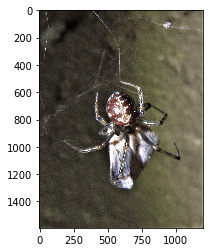

In [13]:
# test: visualisation

bucket_name = 'eva-arthropod'
img_name = 'arthropod_highres/Araneae/1c395363bae7.jpg'
obj = boto3.resource('s3').Object(bucket_name, img_name)
tmp_name = '/tmp/'+img_name.split('/')[-1]
print(tmp_name)
# now we can actually download from S3 to a local place
with open(tmp_name, 'wb') as f:
    obj.download_fileobj(f)
    f.flush()
    f.close()
    image = Image.open(tmp_name)
 
plt.imshow(image)

In [14]:
### Data loaders ###

train_dataset = ArthropodDataset( train_files, transform = train_transform)
val_dataset = ArthropodDataset(val_files, transform = train_transform)
test_dataset=ArthropodDataset(test_files, transform = test_transform)

# dataloaders objects corresponding to the train and test sets

B=16 # batch size for the data loaders
print("Batch size : ", B)

NUM_WORKERS = 15

dl_train=torch.utils.data.DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=NUM_WORKERS) 
dl_val=torch.utils.data.DataLoader(val_dataset, batch_size=B, shuffle=True, num_workers=NUM_WORKERS)  
dl_test=torch.utils.data.DataLoader(test_dataset, batch_size=B, shuffle=False, num_workers=NUM_WORKERS)
print("Number of training batches: ",  len(dl_train))
print("Number of val batches: ",  len(dl_val))
print("Number of test batches: ",  len(dl_test))

Batch size :  16
Number of training batches:  713
Number of val batches:  161
Number of test batches:  89


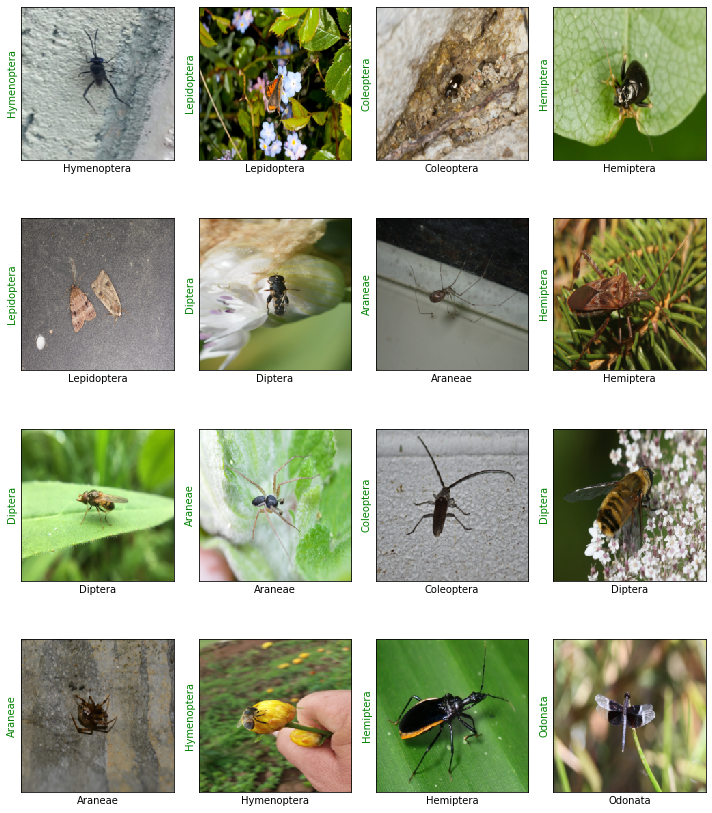

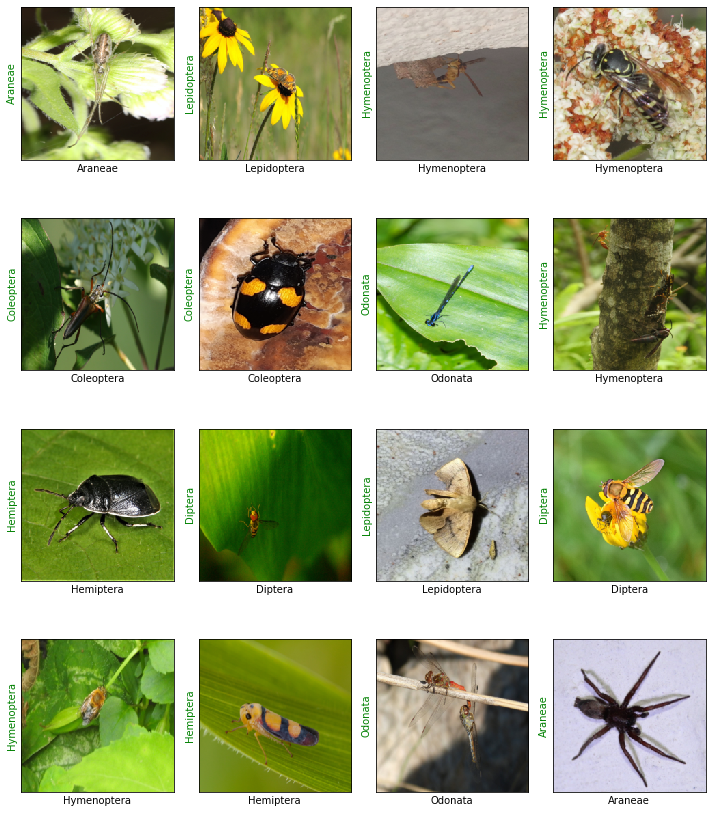

In [15]:
### Data visualization ###
# B : batchsize = 16
def show_images(images, labels, preds):
    plt.figure(figsize=(10, 12))
    for i, image in enumerate(images):
        plt.subplot(4, 4, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
    
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

images, labels = next(iter(dl_test))
show_images(images, labels, labels)

__Define the network  architecture__

Custom network with 3 convolutional layers and 2 fully connected layers.

Tests

 - dropout is not great here (1D dropout : During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call. Furthermore, the outputs are scaled by a factor of 1/(1-p) during training. This means that during evaluation the module simply computes an identity function. Choice : p = 0.2, dropout layer between the first and the second fully connected layers. Dropout not kept for this CNN, either too small or not trained on a high enough number of epochs to have a return on investment with dropout.
 
- optimizer : Adam, RMSprop and SGD tested. SGD performs better here. 

NB : CrossEntropyLoss =  F.nll_loss(output, target) as loss function + F.log_softmax(x, dim=1) as final layer


In [16]:
NUM_CLASSES = len(class_names)
NUM_CONV_1=16 # also tried : 32, and stride = 1
NUM_CONV_2=32 # also tried : 64
NUM_CONV_3=32 # also tried : 32
NUM_FC=512 # also tried : 1024
p=0.2 # dropout probability

class myCNN(nn.Module):
    def __init__(self):
        super(myCNN,self).__init__()
        self.conv_1 = nn.Conv2d(3,NUM_CONV_1,5,2) # kernel_size = 5, stride = 2, no padding 
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5, stride = 1, no padding 
        self.conv_3 = nn.Conv2d(NUM_CONV_2,NUM_CONV_3,5,1) # kernel_size = 5, , stride = 1, no padding 
        #self.drop = nn.Dropout(p=0.2)        
        self.fc_1 = nn.Linear(10*10*NUM_CONV_3, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_3(x))
        x = F.max_pool2d(x,2,2)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        #x = F.relu(self.drop(self.fc_1(x)))
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

# define model 
model = myCNN()

model.to(device) # puts model on GPU / CPU

myCNN(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=3200, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=7, bias=True)
)

In [17]:
# number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters : ", params) # 1.682.183

Number of trainable parameters :  1682183


## 2. Training and evaluation 

Contents : 
* Training without hp tuning. 
* Metrics and visualizations to evaluate the model.

__Training__

In [18]:
# optimization hyperparameters

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 
#optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.02)

loss_fn = nn.CrossEntropyLoss()  

In [19]:
## Training v1 ##

def train(model, N_epochs, train_loader, test_loader):
    """
    model : neural network like myCNN()
    N_epochs : int
    train_loader : dataloader instance to iterate over training batches
    test_loader : idem, for val or test set
    """
    start = time.time()
    print('Starting training..')
    for epoch in range(N_epochs):
        print('\n'+'='*20+'\nStarting epoch '+str(epoch+1) + '/'+str(N_epochs)+'\n'+'='*20)
        # training
        model.train() # mode "train" agit sur "dropout" ou "batchnorm"
        for batch_idx, (x, target) in enumerate(train_loader):
            #print(len(x))
            #print(x.shape)
            optimizer.zero_grad()
            x, target = Variable(x).to(device), Variable(target).to(device)
            #print(len(x))
            out = model(x)
            #print(len(out), len(target))
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            if batch_idx %100 ==0:
                print('epoch {} - batch {} [{}/{}] - training loss: {}'.format(epoch+1,batch_idx,batch_idx*len(x),
                        len(train_loader.dataset),loss.item()))
        # testing -- val set
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (x, target) in enumerate(test_loader):
                x, target = x.to(device), target.to(device)
                out = model(x)
                loss = loss_fn(out, target)
                # _, prediction = torch.max(out.data, 1)
                prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
                correct += prediction.eq(target.view_as(prediction)).sum().item()
        taux_classif = 100. * correct / len(test_loader.dataset)
        print('Val Accuracy: {}/{} (i.e. {:.2f}%, error: {:.2f}%)\n'.format(correct,
         len(test_loader.dataset), taux_classif, 100.-taux_classif))
    print("Elapsed : %s min" %ceil((time.time()-start)/60))
    return model

__Experiment : at which point does the model begin to overfit ?__

After 16 epochs it was still not clearly overfitting. But we cannot afford to train our models for such a long time. Bigger models are longer to train and since an AWS session times out after 12 hours of activity, we would systematically be running out of time. Of course we have thought of checkpointing and we have implemented it too. But return on invested training time stays low. So we arbitrarily train our models for around 10 epochs.

In [20]:
## Training v2 ##

N_epochs = 14 

def train_with_history(model, N_epochs, train_loader, test_loader, checkpoint_dir = None):
    """
    model : neural network like myCNN()
    N_epochs : int
    train_loader : dataloader instance to iterate over training batches
    test_loader : idem, for val or test set
    """
    start = time.time()
    print('Starting training..')
    
    ### added 
    """
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    """
    ### end added
    
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    batch_idx_list = []
    epoch_list = [n for n in range(N_epochs)]
    
    for epoch in range(N_epochs):
        print('\n'+'='*20+'\nStarting epoch '+str(epoch+1) + '/'+str(N_epochs)+'\n'+'='*20)
        # training
        model.train() # mode "train" agit sur "dropout" ou "batchnorm"
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            x, target = Variable(x).to(device), Variable(target).to(device)
            out = model(x)
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            if batch_idx %100 ==0:
                print('epoch {} - batch {} [{}/{}] - training loss: {}'.format(epoch+1,batch_idx,batch_idx*len(x),
                        len(train_loader.dataset),loss.item()))
                train_loss_history.append(loss.item())
                batch_idx_list.append(batch_idx+epoch*ceil(len(train_loader.dataset)/len(x))) # number of batches already processed
        
        ### added
        #path = os.path.join(checkpoint_dir, "checkpoint")
        #torch.save((net.state_dict(), optimizer.state_dict()), path)
        ### end added
        
        # testing -- val set
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (x, target) in enumerate(test_loader):
                x, target = x.to(device), target.to(device)
                out = model(x)
                loss = loss_fn(out, target)
                # _, prediction = torch.max(out.data, 1)
                prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
                correct += prediction.eq(target.view_as(prediction)).sum().item()
        taux_classif = 100. * correct / len(test_loader.dataset)
        print('Val Accuracy: {}/{} (i.e. {:.2f}%, error: {:.2f}%)\n'.format(correct,
         len(test_loader.dataset), taux_classif, 100.-taux_classif))
        val_loss_history.append(loss.item())
        val_acc_history.append(taux_classif)
    
    print("Elapsed : %s min" %ceil((time.time()-start)/60))
    hist_dic= {'train_loss': train_loss_history, 'epochs' : epoch_list,
             'val_loss': val_loss_history, 'val_acc': val_acc_history, 'batches' : batch_idx_list}
    return model, hist_dic


    
#trained_model, hist_dic = train_with_history(model, N_epochs, dl_train, dl_val)


In [21]:
# checkpointing utils

def load_checkpoint(filename='cp_CNN', checkpoint_dir='/models', bucket=bucket):
    """
    Input
    ------
    filename : str, choose something like cp_modelType_version_epoch
    checkpoint_dir : str, "/models"
    bucket : str, "eva_arthropod"
    
    Output
    ------
    model_state : model state dict
    optimizer_state : optimizer state dict
    """
    boto3.resource('s3').meta.client.download_file(bucket, 
                                                   os.path.join(checkpoint_dir, filename), 
                                                   '/tmp/loaded_checkpoint')
    model_state, optimizer_state = torch.load('/tmp/checkpoint')
    print("Successfully downloaded checkpoint from s3 bucket : " %filename)
    return model_state, optimizer_state 

def save_checkpoint(net, optimizer, filename='cp_CNN', checkpoint_dir='models', bucket=bucket):
    torch.save((net.state_dict(), optimizer.state_dict()), '/tmp/saved_checkpoint')
    s3_path = os.path.join(checkpoint_dir, filename)
    print(s3_path)
    boto3.resource('s3').meta.client.upload_file(Filename = '/tmp/saved_checkpoint', 
                                                 Bucket = bucket, 
                                                 Key = s3_path)
    print("Successfully uploaded checkpoint %s to s3 bucket under name %s." %(filename, s3_path))

# test
# save_checkpoint(model, optimizer)

In [22]:
## Training with checkpoints ##


def train_with_history(model, N_epochs, train_loader, test_loader, make_checkpoints = True, warm_start = False):
    """
    model : neural network like myCNN()
    N_epochs : int
    train_loader : dataloader instance to iterate over training batches
    test_loader : idem, for val or test set
    """
    start = time.time()
    print('Starting training..')
    
    if warm_start :
        model_state, optimizer_state  = load_checkpoint()
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
            
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    batch_idx_list = []
    epoch_list = [n for n in range(N_epochs)]
    
    for epoch in range(N_epochs):
        print('\n'+'='*20+'\nStarting epoch '+str(epoch+1) + '/'+str(N_epochs)+'\n'+'='*20)
        # training
        model.train() # mode "train" agit sur "dropout" ou "batchnorm"
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            x, target = Variable(x).to(device), Variable(target).to(device)
            out = model(x)
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            if batch_idx %100 ==0:
                print('epoch {} - batch {} [{}/{}] - training loss: {}'.format(epoch+1,batch_idx,batch_idx*len(x),
                        len(train_loader.dataset),loss.item()))
                train_loss_history.append(loss.item())
                batch_idx_list.append(batch_idx+epoch*ceil(len(train_loader.dataset)/len(x))) # number of batches already processed
        
        if make_checkpoints :
            save_checkpoint(model, optimizer, 'cp_CNN')
        
        # testing -- val set
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (x, target) in enumerate(test_loader):
                x, target = x.to(device), target.to(device)
                out = model(x)
                loss = loss_fn(out, target)
                # _, prediction = torch.max(out.data, 1)
                prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
                correct += prediction.eq(target.view_as(prediction)).sum().item()
        taux_classif = 100. * correct / len(test_loader.dataset)
        print('Val Accuracy: {}/{} (i.e. {:.2f}%, error: {:.2f}%)\n'.format(correct,
         len(test_loader.dataset), taux_classif, 100.-taux_classif))
        val_loss_history.append(loss.item())
        val_acc_history.append(taux_classif)
    
    print("Elapsed : %s min" %ceil((time.time()-start)/60))
    hist_dic= {'train_loss': train_loss_history, 'epochs' : epoch_list,
             'val_loss': val_loss_history, 'val_acc': val_acc_history, 'batches' : batch_idx_list}
    return model, hist_dic


# model, N_epochs, train_loader, test_loader, make_checkpoints = True, warm_start = False    
trained_model, hist_dic = train_with_history(model, N_epochs, dl_train, dl_val)


Starting training..

Starting epoch 1/14
epoch 1 - batch 0 [0/11393] - training loss: 1.9534529447555542
epoch 1 - batch 100 [1600/11393] - training loss: 1.9728243350982666
epoch 1 - batch 200 [3200/11393] - training loss: 1.9017976522445679
epoch 1 - batch 300 [4800/11393] - training loss: 1.9030405282974243
epoch 1 - batch 400 [6400/11393] - training loss: 1.9515851736068726
epoch 1 - batch 500 [8000/11393] - training loss: 1.9343805313110352
epoch 1 - batch 600 [9600/11393] - training loss: 1.851111888885498
epoch 1 - batch 700 [11200/11393] - training loss: 1.910240650177002
models/cp_CNN
Successfully uploaded checkpoint cp_CNN to s3 bucket under name models/cp_CNN.
Val Accuracy: 579/2562 (i.e. 22.60%, error: 77.40%)


Starting epoch 2/14
epoch 2 - batch 0 [0/11393] - training loss: 1.9218469858169556
epoch 2 - batch 100 [1600/11393] - training loss: 1.939711093902588
epoch 2 - batch 200 [3200/11393] - training loss: 1.8223586082458496
epoch 2 - batch 300 [4800/11393] - training l

In [23]:
# Model saving

filename = 'model_cnn_0.pth'
torch.save(trained_model.state_dict(), filename)
print("saved model locally to {}".format(filename))

boto3.resource('s3').meta.client.upload_file(filename, bucket, filename)

saved model locally to model_cnn_0.pth


In [24]:
# test : how to reopen model - OK
boto3.resource('s3').meta.client.download_file(bucket, filename, os.path.join('/tmp', filename))
state_dic = torch.load(os.path.join('/tmp', filename))
new_model = myCNN()
new_model.load_state_dict(state_dic)

<All keys matched successfully>

### Evaluation

Note : test with 3 classe without training : Average loss: 0.0695, Accuracy: 379/1140 (33.246%)
 consistent with a 1/3 guessing principle. 
 
Test with 7 classes without training : Average loss: 0.1223, Accuracy: 396/2562 (15.457%) slightly better than random.

In [25]:
### Simple accuracy computation ###

def evaluate(model, data_loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            #print(data.shape)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
        
            outputs = model(data)            
            loss += loss_fn(outputs, target).item() #data[0]            
            pred = outputs.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                
    loss /= len(data_loader.dataset)        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    return None

evaluate(model, dl_val) 


Average loss: 0.1399, Accuracy: 686/2562 (26.776%)



__Macro and micro metrics__

In [27]:
### Get full performance metrics ###
## Version 2 -- Probabilities to feed ROC curves ##

def get_pred(model, data_loader):
    model.eval()
    pred = torch.LongTensor()
    target= torch.LongTensor()
    proba = torch.LongTensor()
    s = torch.nn.Softmax(dim=1)
    
    with torch.no_grad():
        for data_i, target_i in data_loader:
            if torch.cuda.is_available():
                data_i = data_i.cuda()
                
            outputs = model(data_i)
            pred_i = np.argmax(outputs,axis=1)
            pred = torch.cat((pred, pred_i), dim=0)
            target = torch.cat((target, target_i), dim=0)
            proba = torch.cat((proba, s(outputs)), dim=0)
        
    return pred, target, proba


train_pred, train_target, train_proba = get_pred(model, dl_train) # trained_model
val_pred, val_target, val_proba = get_pred(model, dl_val) # trained_model

print("\nPerformance on training set")
print(classification_report(train_target, train_pred, target_names=class_names))
print("\nPerformance on val set")
print(classification_report(val_target, val_pred, target_names=class_names))


Performance on training set
              precision    recall  f1-score   support

     Araneae       0.68      0.16      0.26      1849
  Coleoptera       0.20      0.92      0.33      1541
     Diptera       0.48      0.15      0.23      1461
   Hemiptera       0.69      0.09      0.16      1818
 Hymenoptera       0.48      0.27      0.34      1479
 Lepidoptera       0.57      0.48      0.52      1537
     Odonata       0.78      0.48      0.59      1708

    accuracy                           0.35     11393
   macro avg       0.55      0.36      0.35     11393
weighted avg       0.56      0.35      0.34     11393


Performance on val set
              precision    recall  f1-score   support

     Araneae       0.42      0.09      0.15       366
  Coleoptera       0.19      0.84      0.31       366
     Diptera       0.39      0.11      0.17       366
   Hemiptera       0.37      0.05      0.09       366
 Hymenoptera       0.29      0.13      0.18       366
 Lepidoptera       0.39  

__Focus : ROC curves and area under ROC for a multiclass problem__
 
NB : See 3.3.2.15.2. Multi-class case [here](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

Another evaluation measure for multi-label classification is macro-averaging, which gives equal weight to the classification of each label.
Here in order to plot the ROC curves for the multilabel problem, we compute the macro-average ROC curve and the corresponding ROC areas.   

Note : The `sklearn.metrics.roc_auc_score` function can be used for multi-class classification with two schemes. The One-vs-One scheme compares every unique pairwise combination of classes. The One-vs-Rest schema compares every class against the rest of the others. Here we calculate the AUC using the OvO scheme. We report a macro average, and a prevalence-weighted average.

In [28]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from scipy import interp
from itertools import cycle

In [29]:
# From torch.tensors to numpy.arrays

print(val_target.size())
val_target_array = val_target.detach().cpu().numpy()

# one-hot encoding needed for multiclass ROC
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

val_target_array = get_one_hot(val_target_array, NUM_CLASSES)
print(val_target_array.shape)


val_proba_array = val_proba.detach().cpu().numpy()
print(val_proba_array.shape)

torch.Size([2562])
(2562, 7)
(2562, 7)


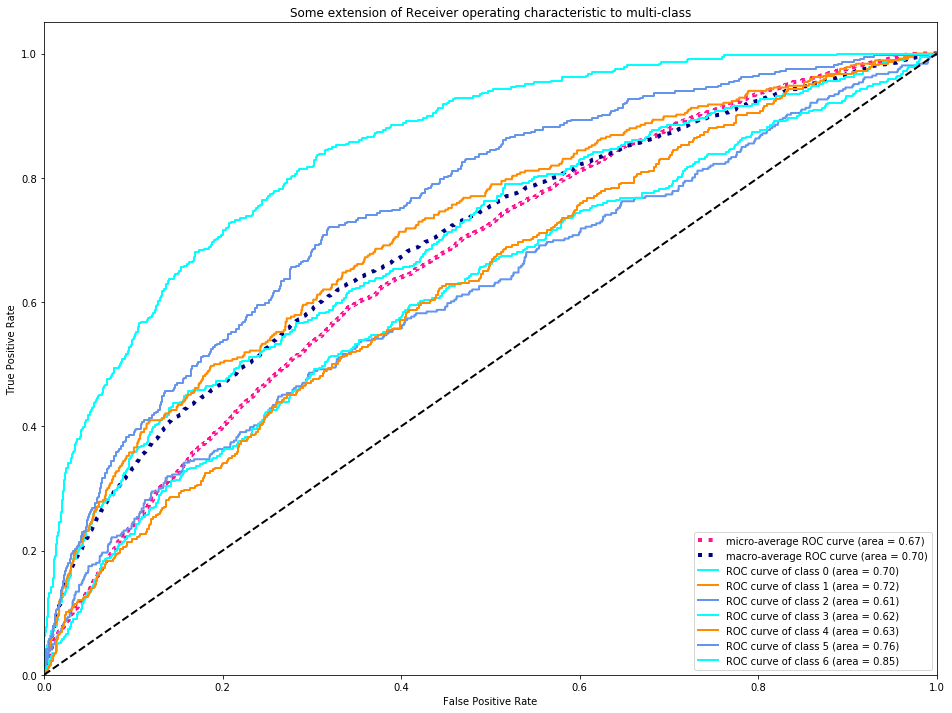

In [30]:
## Plot ## 
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(val_target_array[:, i], val_proba_array[:, i])  # y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(val_target_array.ravel(), val_proba_array.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [31]:
## Area under ROC for a multiclass problem - One-vs-One ##

macro_roc_auc_ovo = roc_auc_score(val_target, val_proba, multi_class="ovo", average="macro")

weighted_roc_auc_ovo = roc_auc_score(val_target, val_proba, multi_class="ovo", average="weighted")
 

print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))


One-vs-One ROC AUC scores:
0.696251 (macro),
0.696251 (weighted by prevalence)


__Learning curves__

In [32]:
def plot_learning_curves(hist_dic):
    train_loss_history, epoch_list = hist_dic['train_loss'], hist_dic['epochs']
    val_loss_history, val_acc_history, batch_idx_list = hist_dic['val_loss'], hist_dic['val_acc'], hist_dic['batches']  
    # plot learning curves - training set
    plt.plot(batch_idx_list, train_loss_history,  
             color='blue', linestyle='dashed', 
             marker = '*', markerfacecolor='black')
    plt.xlabel("Number of processed training batches")
    plt.ylabel("Training loss")
    plt.title('Training loss across training')
    plt.show()
    # plot learning curves - val set
    plt.plot(epoch_list, val_loss_history, 
             color = 'red', linestyle = 'dashed', 
             marker = '*', markerfacecolor = 'black')
    plt.xlabel("Number of epochs")
    plt.ylabel("Val loss")
    plt.title('Val loss across training')
    plt.show()
    plt.plot(epoch_list, val_acc_history,  
             color = 'green', linestyle = 'dashed', 
             marker = '*', markerfacecolor = 'black')
    plt.xlabel("Number of epochs")
    plt.ylabel("Val accuracy")
    plt.title('Val accuracy across training')
    plt.show()

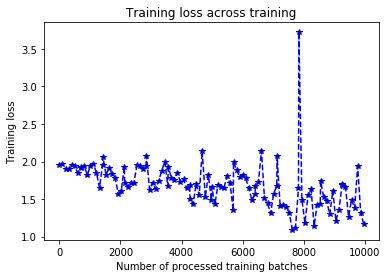

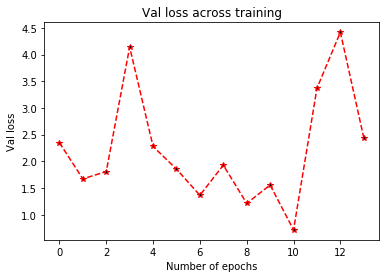

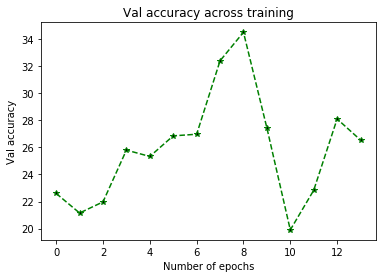

In [33]:
plot_learning_curves(hist_dic)

__Optional : save predictions as CSVs__

In [ ]:
### Saving results ###

saving = False

if saving:
    print("Saving results")
    train_df = pd.DataFrame({"pred":train_pred, "target": train_target})
    val_df = pd.DataFrame({"pred":val_pred, "target": val_target})
    train_df.to_csv("train_results_CNN.csv")
    val_df.to_csv("val_results_CNN.csv")
    
# Print model's state_dict
def print_model_info(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
    # Print optimizer's state_dict
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])
    return None

#print_model_info(resnet18)

## 3. Hyperparameter tuning

We perform a (grid) search to select the best combination of batch size, learning rate and optimizer. We will keep the best model as reference. 

We use the framework of ray.tune to benefit from its reporting functionalities during hyperparameter tuning. Therefore we need to repackage the code a bit. We followed this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html). 

Alternative : https://discuss.pytorch.org/t/what-is-the-best-way-to-perform-hyper-parameter-search-in-pytorch/19943

In [15]:
!pip install ray[tune]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [16]:
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [17]:
### Data loaders ###

def load_data(train_files, val_files, test_files):

    # train set : 224*224 images as input because min input size of mobilenet, resnet18 etc architectures 
    # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] because they are the values of the ImageNet data     
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(224, 224)),
        #torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # test set : same steps except the data augmentation step     
    # idem for the mean and std dev values    
    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_dataset = ArthropodDataset(train_files, transform = train_transform)
    val_dataset = ArthropodDataset(val_files, transform = train_transform)
    test_dataset=ArthropodDataset(test_files, transform = test_transform)

    
    return train_dataset, val_dataset, test_dataset

# test OK

Hyperparameter choice : 
* network will not be configurable id est the number of layers or their caracteristics will not be tuned here;
* the optimizer : SGD, RMSProp or Adam. RMSProp was used to train the original MobileNet model we use for transfer learning. We also test an alternative optimizer. We need to run the hp tuning process several times.
* learning rate : the learning rate value is to be tuned, it is one of the most impactful hyperparameters in deep learning;
* batch size

Note : 

    CLASS torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    CLASS torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


__Hp tuning v2 : tune the architecture too__

In [18]:
### Search space ###

N_epochs = 8

NUM_WORKERS = 2

config = {            
            "lr": tune.loguniform(1e-4, 1e-1),
            "batch_size": tune.choice([4, 8, 16]),
            "NUM_CONV_1": tune.choice([16, 32]),
            "NUM_FC": tune.choice([512, 1024])
}

In [19]:
NUM_CLASSES = len(class_names)
#NUM_CONV_1=16 # try 32
NUM_CONV_2=32 # try 64
NUM_CONV_3=32 # try 64
#NUM_FC=512 # (try 1024)

class myCNN(nn.Module):
    def __init__(self, NUM_CONV_1, NUM_FC):
        super(myCNN,self).__init__()
        self.conv_1 = nn.Conv2d(3,NUM_CONV_1,5,2) # kernel_size = 5, stride = 2, no padding 
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5, stride = 1, no padding 
        self.conv_3 = nn.Conv2d(NUM_CONV_2,NUM_CONV_3,5,1) # kernel_size = 5, , stride = 1, no padding 
        #self.drop = nn.Dropout(p=0.2)        
        self.fc_1 = nn.Linear(10*10*NUM_CONV_3, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_3(x))
        x = F.max_pool2d(x,2,2)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        #x = F.relu(self.drop(self.fc_1(x)))
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

# test 
myCNN(16, 512)

myCNN(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=3200, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=7, bias=True)
)

In [20]:
### Training ###

# with multiplicative learning rate decay  


def train_n_tune(config, checkpoint_dir=None): # config, N_epochs, train_files, val_files, test_files, 
    
    net = myCNN(config["NUM_CONV_1"], config["NUM_FC"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer =  torch.optim.SGD(net.parameters(), lr=config["lr"]) ## To adapt ##
    lr_lambda = lambda x : 0.9999 
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1, verbose=False)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_subset, val_subset, testset = load_data(train_files, val_files, test_files)

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=1)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=1)

    def test_accuracy(net, device="cpu"): # train_files, val_files, test_files are global 
        testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS)
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return correct / total
    
    for epoch in range(N_epochs):  # loop over the dataset multiple times
        print("--- Epoch %s ---" %(epoch+1))
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            try :
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                # print statistics
                running_loss += loss.item()
                epoch_steps += 1
                if i % 200 == 199:  # print every 200 mini-batches
                    print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                    running_loss / epoch_steps))
                    running_loss = 0.0
                    
            except : 
                print("Batch number %s left out / Training (OSError : missing bytes)" %i)
                # OSError: image file is truncated (X bytes not processed)
        print("Average loss for epoch %s : %s" %(epoch+1, running_loss/epoch_steps))
        
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            try :
                with torch.no_grad():
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    loss = criterion(outputs, labels)
                    val_loss += loss.cpu().numpy()
                    val_steps += 1
            except :
                print("Batch number %s left out / Validation (OSError : missing bytes)" %i)

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

    print("Finished Training")
    test_acc = test_accuracy(net, device)
    print("Current test set accuracy: {}".format(test_acc))
    


In [ ]:
### Main : perform hp tuning ###

# train_files, val_files, test_files,  already defined above 

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    
    train_dataset, val_dataset, test_dataset = load_data(train_files, val_files, test_files)
    
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    reporter = CLIReporter(
        # parameter_columns=["lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    
    result = tune.run(
        partial(train_n_tune), # config=config, N_epochs=max_num_epochs, train_files, val_files, test_files
        resources_per_trial={"cpu": 8, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model =  myCNN(best_trial.config["NUM_CONV_1"], best_trial.config["NUM_FC"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)
    
    def test_accuracy(net, device="cpu"): # train_files, val_files, test_files are global 
        testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS)
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return correct / total
    
    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=6, max_num_epochs=10, gpus_per_trial=0)

2021-02-17 16:48:43,053	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-02-17 16:48:43,830	WARNING experiment.py:292 -- No name detected on trainable. Using DEFAULT.
2021-02-17 16:48:43,832	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 3.3/31.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 8/8 CPUs, 0/0 GPUs, 0.0/17.19 GiB heap, 0.0/5.91 GiB objects
Result logdir: /home/ec2-user/ray_results/DEFAULT_2021-02-17_16-48-43
Number of trials: 1/6 (1 RUNNING)
+---------------------+----------+-------+--------------+----------+--------------+-----------+
| Trial name          | status   | loc   |   NUM_CONV_1 |   NUM_FC |   batch_size |        lr |
|---------------------+----------+-------+--------------+----------+--------------+-----------|
| DEFAULT_feeaf_00000 | RUNNING  |       |           32 |      512 |           16 | 0.0108431 |
+---------------------+----------+-------+--------------+----------+--------------+-----------+


(pid=6114) --- Epoch 1 ---
(pid=6114) [1,   200] loss: 1.939
(pid=6114) [1,   400] loss: 0.958
(pid=6114) [1,   600] loss: 0.632
(pid=6114) Average loss for epo